<a href="https://colab.research.google.com/github/arasorietnom/StrokeHealthData-Clustering-Logistic-Regression/blob/main/STROKE_AND_HEALTH_DEMOGRAPHICS_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STROKE AND HEALTH DEMOGRAPHICS**:

[Kaggle Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data)

Disclaimer: for educational purposes (no real data collection was verified).

# Part 1: Subset K-Means Clustering for Health Profile Segmentation

In [6]:
# System and OS
import os
import glob
import sys
from zipfile import ZipFile

# Data Handling
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Machine Learning Models and Utilities
from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader

# Image Processing
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress Bar
from tqdm.notebook import tqdm as tqdm_notebook


In [7]:
from google.colab import files

uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


In [8]:
dataset = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

In [9]:
dataset

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [10]:
dataset.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


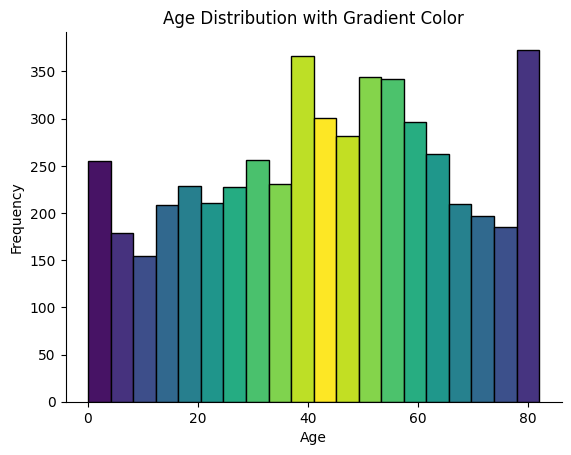

In [11]:
# age bargraph
age_data = dataset['age']
mean_age = age_data.mean()

# histogram
n, bins, patches = plt.hist(age_data, bins=20, edgecolor='black')

# bin colors based on their distance from the mean and color intensity based on the closeness to the mean
for i, patch in enumerate(patches):
    bin_center = (bins[i] + bins[i+1]) / 2
    color_intensity = 1 - abs(bin_center - mean_age) / max(abs(bins - mean_age))
    patch.set_facecolor(plt.cm.viridis(color_intensity))

# titles and labels
plt.title('Age Distribution with Gradient Color')
plt.xlabel('Age')
plt.ylabel('Frequency')

# top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

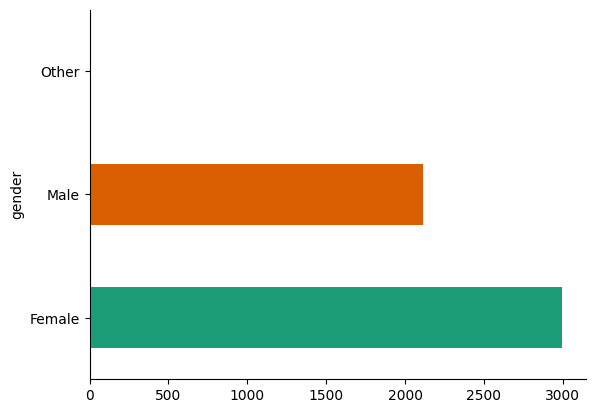

In [12]:
# @title gender

dataset.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

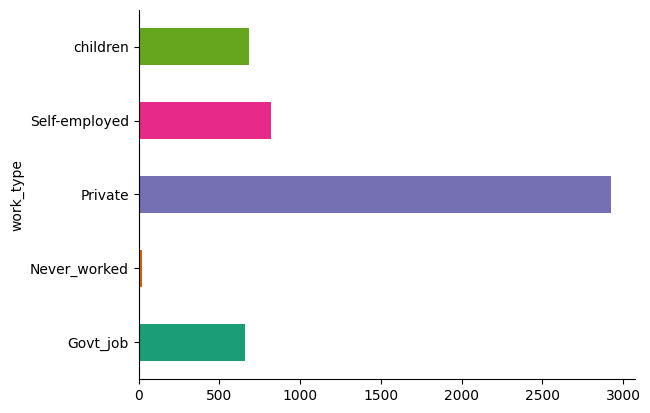

In [13]:
# @title work_type

dataset.groupby('work_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

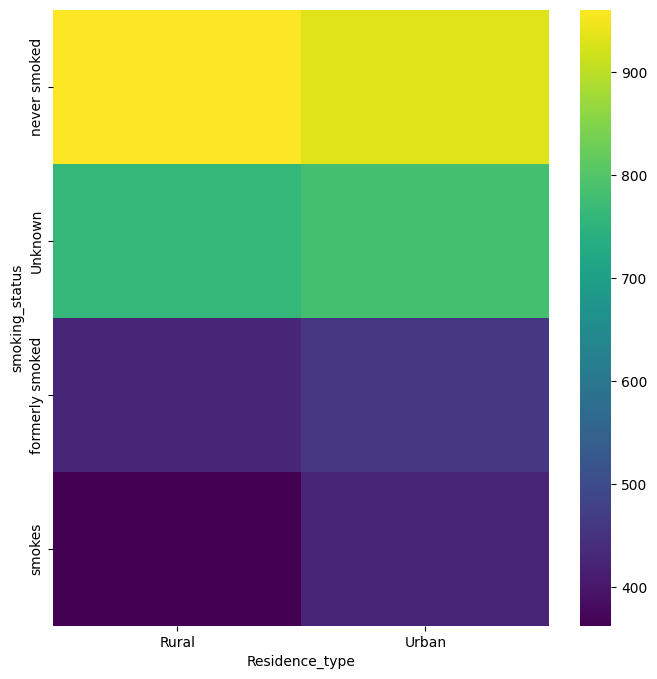

In [14]:
# @title Residence_type vs smoking_status

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['smoking_status'].value_counts()
    for x_label, grp in dataset.groupby('Residence_type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Residence_type')
_ = plt.ylabel('smoking_status')

# Experimental random subset

In [15]:
# setting random seed for reproducibility
np.random.seed(42)

# choose 500 indices randomly without replacement
subset_indices = np.random.choice(dataset.index, 500, replace=False)

# subset creation for clustering
subset = dataset.loc[subset_indices]

In [16]:
# removing rows with missing data from the subset
subset_cleaned = subset.dropna()
print(subset_cleaned.head())

         id  gender   age  hypertension  heart_disease ever_married  \
4688  40041    Male  31.0             0              0           No   
4478  55244    Male  40.0             0              0          Yes   
3849  70992  Female   8.0             0              0           No   
4355  38207  Female  79.0             1              0          Yes   
3826   8541  Female  75.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi smoking_status  \
4688  Self-employed          Rural              64.85  23.0        Unknown   
4478  Self-employed          Rural              65.29  28.3   never smoked   
3849       children          Urban              74.42  22.5        Unknown   
4355  Self-employed          Rural              76.64  19.5   never smoked   
3826       Govt_job          Rural              94.77  27.2   never smoked   

      stroke  
4688       0  
4478       0  
3849       0  
4355       0  
3826       0  


In [17]:
subset = subset_cleaned

In [18]:
subset #check

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4688,40041,Male,31.0,0,0,No,Self-employed,Rural,64.85,23.0,Unknown,0
4478,55244,Male,40.0,0,0,Yes,Self-employed,Rural,65.29,28.3,never smoked,0
3849,70992,Female,8.0,0,0,No,children,Urban,74.42,22.5,Unknown,0
4355,38207,Female,79.0,1,0,Yes,Self-employed,Rural,76.64,19.5,never smoked,0
3826,8541,Female,75.0,0,0,Yes,Govt_job,Rural,94.77,27.2,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1197,26031,Female,14.0,0,0,No,Private,Rural,84.46,21.8,Unknown,0
501,68483,Female,60.0,0,0,Yes,Private,Urban,65.38,41.2,formerly smoked,0
437,5010,Female,2.0,0,0,No,children,Rural,92.48,18.0,Unknown,0
653,72823,Female,79.0,0,0,Yes,Private,Urban,70.35,23.0,formerly smoked,0


In [19]:
subset.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,477.00000,477.000000,477.000000,477.000000,477.000000,477.000000,477.000000
mean,36524.63522,42.395136,0.090147,0.060797,101.372432,28.904822,0.050314
std,21464.87226,22.301449,0.286693,0.239208,40.917388,7.604532,0.218823
min,84.00000,0.320000,0.000000,0.000000,55.280000,13.300000,0.000000
25%,17515.00000,24.000000,0.000000,0.000000,76.580000,23.600000,0.000000
50%,37713.00000,44.000000,0.000000,0.000000,90.040000,28.200000,0.000000
75%,54383.00000,60.000000,0.000000,0.000000,108.680000,32.800000,0.000000
max,72836.00000,82.000000,1.000000,1.000000,254.950000,71.900000,1.000000


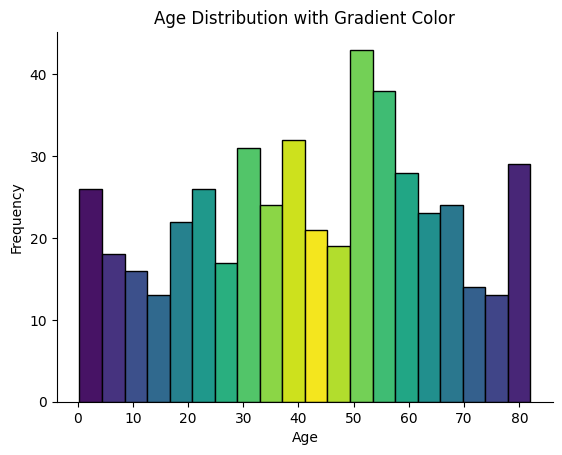

In [20]:
# now the age plot for subset
age_data = subset['age']
mean_age = age_data.mean()

# histogram
n, bins, patches = plt.hist(age_data, bins=20, edgecolor='black')

# bin colors based on their distance from the mean and color intensity based on the closeness to the mean
for i, patch in enumerate(patches):
    bin_center = (bins[i] + bins[i+1]) / 2
    color_intensity = 1 - abs(bin_center - mean_age) / max(abs(bins - mean_age))
    patch.set_facecolor(plt.cm.viridis(color_intensity))

# titles and labels
plt.title('Age Distribution with Gradient Color')
plt.xlabel('Age')
plt.ylabel('Frequency')

# top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

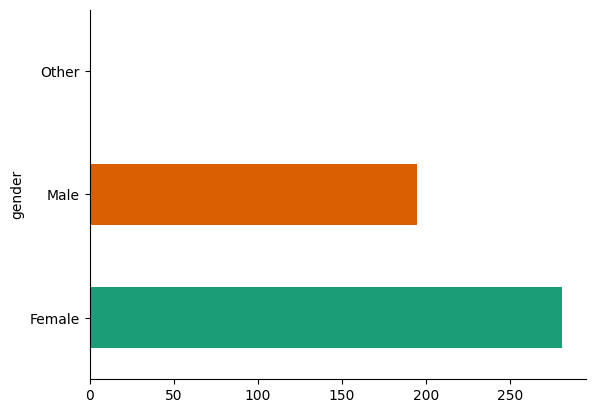

In [21]:
# @title gender

subset.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Clustering for the Subset

In [22]:
# Data Handling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Machine Learning Models and Utilities
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [23]:
features_for_clustering = subset[['avg_glucose_level', 'bmi']]

In [24]:
# defining transformations for the numerical and categorical data
numerical_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                        'work_type', 'Residence_type', 'smoking_status']

# transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), #standardization
        ('cat', OneHotEncoder(), categorical_features) #dummy variables for categorical ones
    ])

In [25]:
# transformers for preprocessing (in another way)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical data
    ('encoder', OneHotEncoder(handle_unknown='ignore')),  # Encode categorical features

])

In [26]:
   # one-hot encoding for categorical variables
subset_encoded = pd.get_dummies(subset, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

In [27]:
print(subset.columns) #check columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


In [28]:
subset_encoded.head() #check transform

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
4688,40041,31.0,0,0,64.85,23.0,0,False,True,False,...,False,False,True,False,True,False,True,False,False,False
4478,55244,40.0,0,0,65.29,28.3,0,False,True,False,...,False,False,True,False,True,False,False,False,True,False
3849,70992,8.0,0,0,74.42,22.5,0,True,False,False,...,False,False,False,True,False,True,True,False,False,False
4355,38207,79.0,1,0,76.64,19.5,0,True,False,False,...,False,False,True,False,True,False,False,False,True,False
3826,8541,75.0,0,0,94.77,27.2,0,True,False,False,...,True,False,False,False,True,False,False,False,True,False


In [29]:
# (various ways of doing it)

K-Means Clustering

In [30]:
# initializing and fitting the K-Means model
kmeans = KMeans(n_clusters=4, random_state=0)  # Adjust 'n_clusters' as necessary
subset['Cluster Membership'] = kmeans.fit_predict(subset[['avg_glucose_level', 'age']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [49]:
# preprocessing steps combined into a single transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# pipeline that includes preprocessing and K-Means clustering
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_clusters=4))
])

# fitting pipeline to the data
pipeline.fit(subset)

# retrieving cluster labels
kmeans_labels = pipeline.named_steps['cluster'].labels_

# adding cluster labels to df
subset['Cluster Membership'] = kmeans_labels

# df head to check the clusters
print("First few rows of the subset with cluster memberships:")
print(subset.head())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


First few rows of the subset with cluster memberships:
         id  gender   age  hypertension  heart_disease ever_married  \
4688  40041    Male  31.0             0              0           No   
4478  55244    Male  40.0             0              0          Yes   
3849  70992  Female   8.0             0              0           No   
4355  38207  Female  79.0             1              0          Yes   
3826   8541  Female  75.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi smoking_status  \
4688  Self-employed          Rural              64.85  23.0        Unknown   
4478  Self-employed          Rural              65.29  28.3   never smoked   
3849       children          Urban              74.42  22.5        Unknown   
4355  Self-employed          Rural              76.64  19.5   never smoked   
3826       Govt_job          Rural              94.77  27.2   never smoked   

      stroke  Cluster Membership  subset_cluster 

In [50]:
subset['Cluster Membership'] = kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

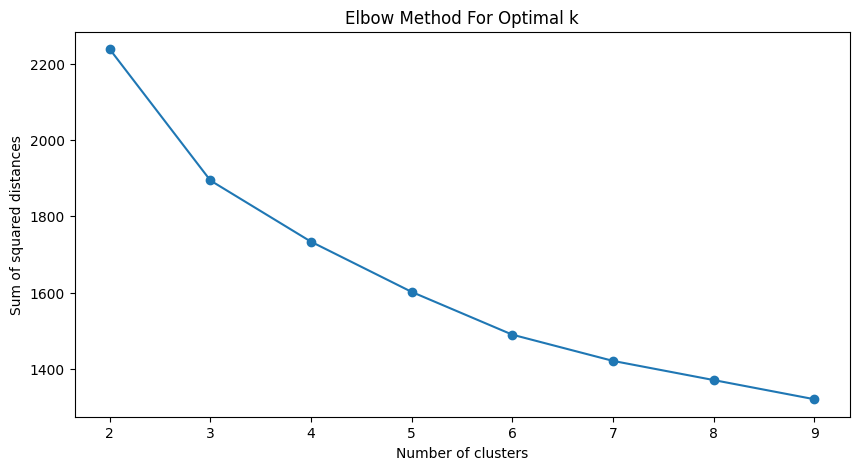

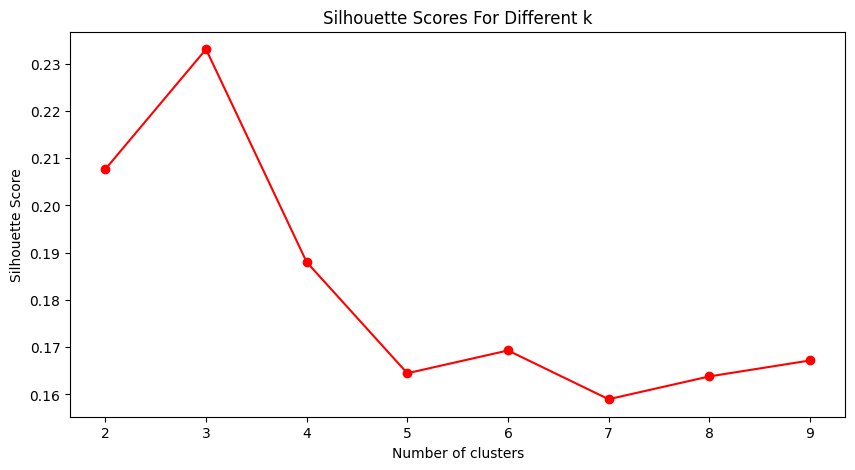

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


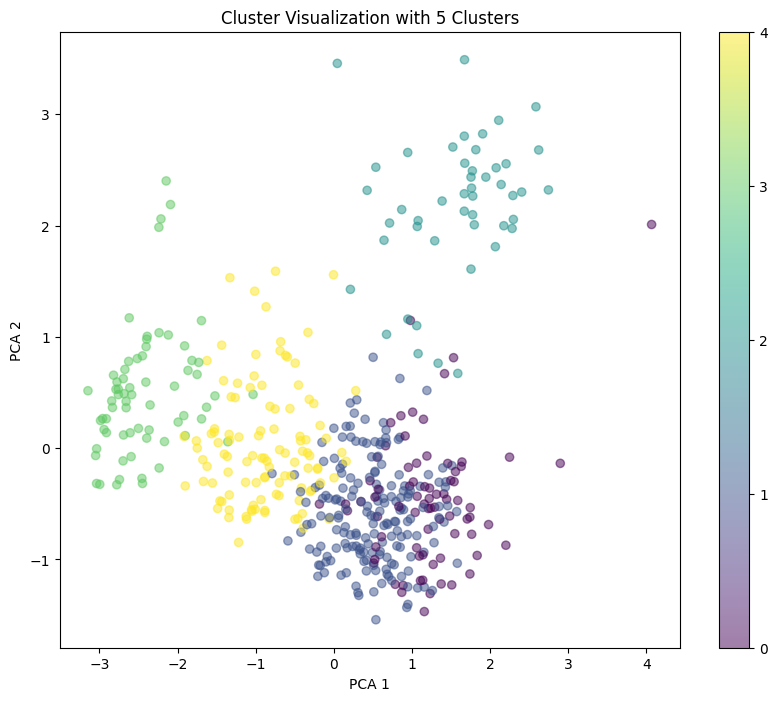

In [51]:
# 'pipeline_features' defined as the preprocessed data
pipeline_features = pipeline.named_steps['preprocessor'].transform(subset)

# elbow Method: compute the sum of squared distances for different values of k
sse = []
silhouette_scores = []
k_list = range(2, 10)  # testing from 2 to 10 clusters
for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pipeline_features)
    sse.append(kmeans.inertia_)  # sum of squared distances to closest cluster center
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(pipeline_features, labels))

# plotting elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(k_list, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# plotting silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(k_list, silhouette_scores, marker='o', color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Different k')
plt.show()

# based on analysis K is defined as:
new_k = 5

# K-Means re-run with the new number of clusters
kmeans = KMeans(n_clusters=new_k, random_state=42)
kmeans.fit(pipeline_features)
labels = kmeans.labels_

# PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(pipeline_features)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar(ticks=range(new_k))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title(f'Cluster Visualization with {new_k} Clusters')
plt.show()

In [35]:
#appending to df and validating
subset['subset_cluster'] = labels
subset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Cluster Membership,subset_cluster
4688,40041,Male,31.0,0,0,No,Self-employed,Rural,64.85,23.0,Unknown,0,1,4
4478,55244,Male,40.0,0,0,Yes,Self-employed,Rural,65.29,28.3,never smoked,0,2,1
3849,70992,Female,8.0,0,0,No,children,Urban,74.42,22.5,Unknown,0,1,3
4355,38207,Female,79.0,1,0,Yes,Self-employed,Rural,76.64,19.5,never smoked,0,2,1
3826,8541,Female,75.0,0,0,Yes,Govt_job,Rural,94.77,27.2,never smoked,0,2,1


PCA: Compare to a Biplot for Loadings

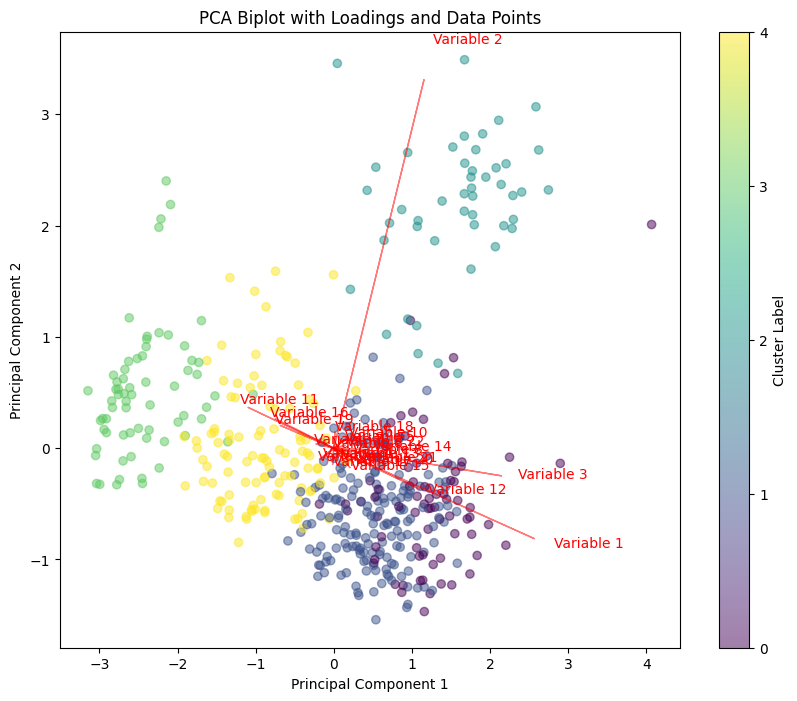

In [36]:
# PCA instance extraction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(pipeline_features)  # This line can be omitted if PCA is already done

# loadings extraction
loadings = pca.components_.T

# plotting PCA results
fig, ax = plt.subplots(figsize=(10, 8))

# plotting the scores (data points)
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.5)

# plotting the loadings (variable vectors)
for i, loading in enumerate(loadings):
    ax.arrow(0, 0, loading[0] * max(reduced_data[:,0]), loading[1] * max(reduced_data[:,1]), color='red', alpha=0.5)
    ax.text(loading[0] * max(reduced_data[:,0]) * 1.1, loading[1] * max(reduced_data[:,1]) * 1.1, f'Variable {i+1}', color='red')

# labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Biplot with Loadings and Data Points')
plt.colorbar(scatter, ticks=range(len(np.unique(labels))), label='Cluster Label')

plt.show()

Heatmap for PCA Loadings

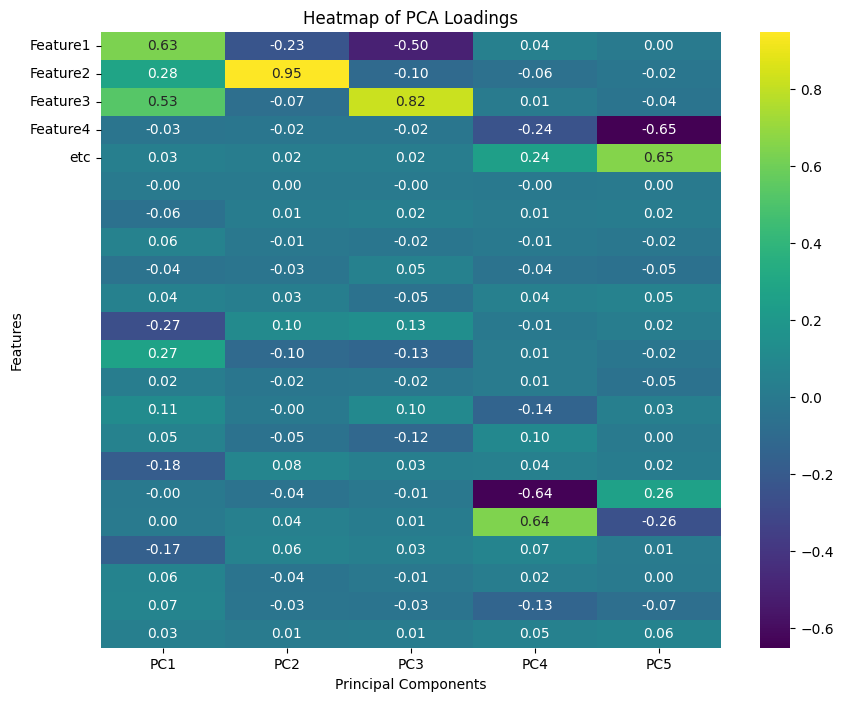

In [37]:
pca = PCA(n_components=5) #5 components analyzed
reduced_data = pca.fit_transform(pipeline_features)
loadings = pca.components_.T

#defining feature names
feature_names = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'etc']

# heatmap of loadings
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, cmap="viridis", annot=True, fmt=".2f", xticklabels=[f'PC{i+1}' for i in range(loadings.shape[1])], yticklabels=feature_names)
plt.title('Heatmap of PCA Loadings')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()


In [38]:
#appending to df and validating
subset['subset_cluster'] = labels
subset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Cluster Membership,subset_cluster
4688,40041,Male,31.0,0,0,No,Self-employed,Rural,64.85,23.0,Unknown,0,1,4
4478,55244,Male,40.0,0,0,Yes,Self-employed,Rural,65.29,28.3,never smoked,0,2,1
3849,70992,Female,8.0,0,0,No,children,Urban,74.42,22.5,Unknown,0,1,3
4355,38207,Female,79.0,1,0,Yes,Self-employed,Rural,76.64,19.5,never smoked,0,2,1
3826,8541,Female,75.0,0,0,Yes,Govt_job,Rural,94.77,27.2,never smoked,0,2,1


In [41]:
subset['Cluster Membership'] = labels

In [42]:
# d dictionary to hold segments
clusters = {}
num_clusters = subset['Cluster Membership'].nunique()  # or set manually the number of clusters used

for i in range(num_clusters):
    clusters[f"cluster_{i}"] = subset[subset['Cluster Membership'] == i]

In [43]:
# basic statistics for each cluster
for i in range(num_clusters):
    print(f"Statistics for cluster {i}:")
    print(clusters[f"cluster_{i}"].describe(), "\n")

Statistics for cluster 0:
                 id        age  hypertension  heart_disease  \
count     76.000000  76.000000     76.000000      76.000000   
mean   34541.105263  50.618421      0.184211       0.065789   
std    20842.790232  13.713222      0.390232       0.249561   
min       99.000000  20.000000      0.000000       0.000000   
25%    18887.750000  40.000000      0.000000       0.000000   
50%    32841.500000  52.000000      0.000000       0.000000   
75%    52829.000000  60.250000      0.000000       0.000000   
max    72784.000000  81.000000      1.000000       1.000000   

       avg_glucose_level        bmi     stroke  Cluster Membership  \
count          76.000000  76.000000  76.000000                76.0   
mean           92.607105  40.727632   0.065789                 0.0   
std            24.088644   6.471159   0.249561                 0.0   
min            56.130000  33.200000   0.000000                 0.0   
25%            77.965000  36.400000   0.000000          

<ipython-input-44-ad62fdb65227>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clusters[f"cluster_{i}"]['age'], label=f'Cluster {i}')
<ipython-input-44-ad62fdb65227>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clusters[f"cluster_{i}"]['age'], label=f'Cluster {i}')
<ipython-input-44-ad62fd

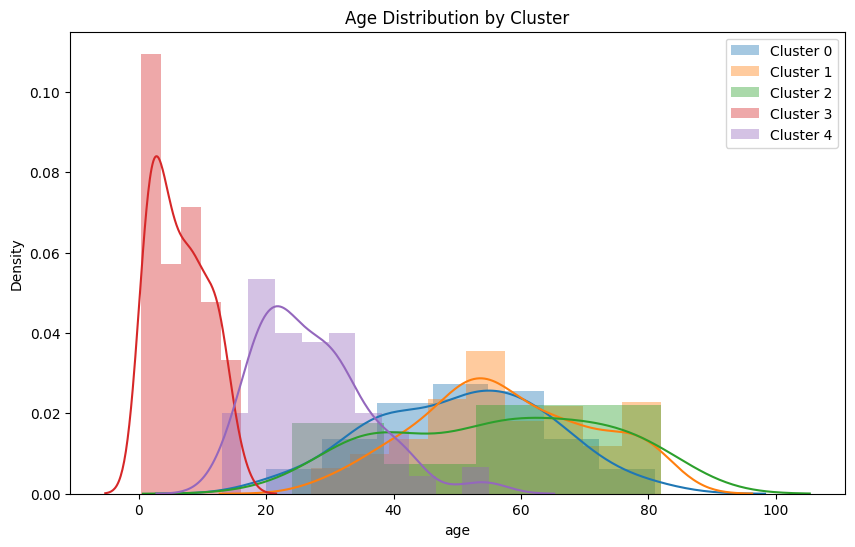

In [44]:
# distribution of 'age' across clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    sns.distplot(clusters[f"cluster_{i}"]['age'], label=f'Cluster {i}')
plt.title('Age Distribution by Cluster')
plt.legend()
plt.show()

In [45]:
# Assuming 'subset' already has 'Cluster Membership' assigned
num_clusters = subset['Cluster Membership'].nunique()  # get the number of unique clusters

clusters = {i: subset[subset['Cluster Membership'] == i] for i in range(num_clusters)}

<ipython-input-46-90bf80f04943>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clusters[i][variable], hist=False, kde=True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-46-90bf80f04943>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or 

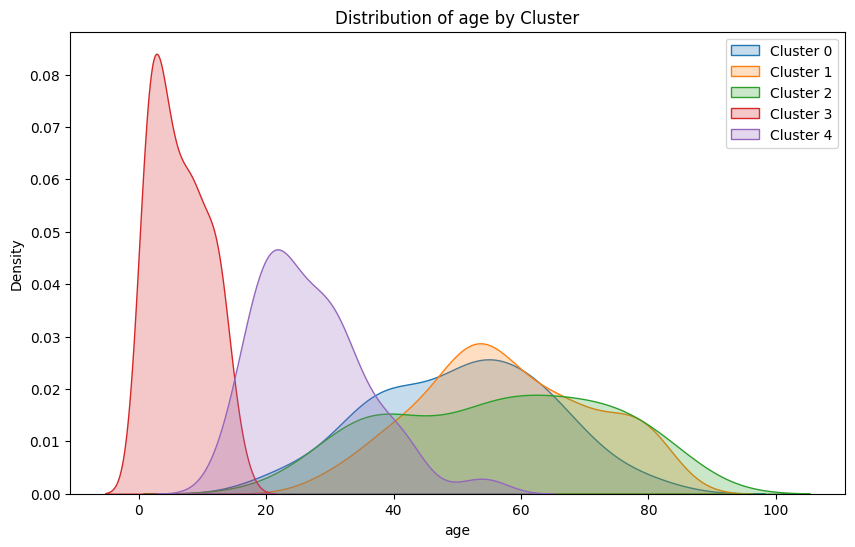

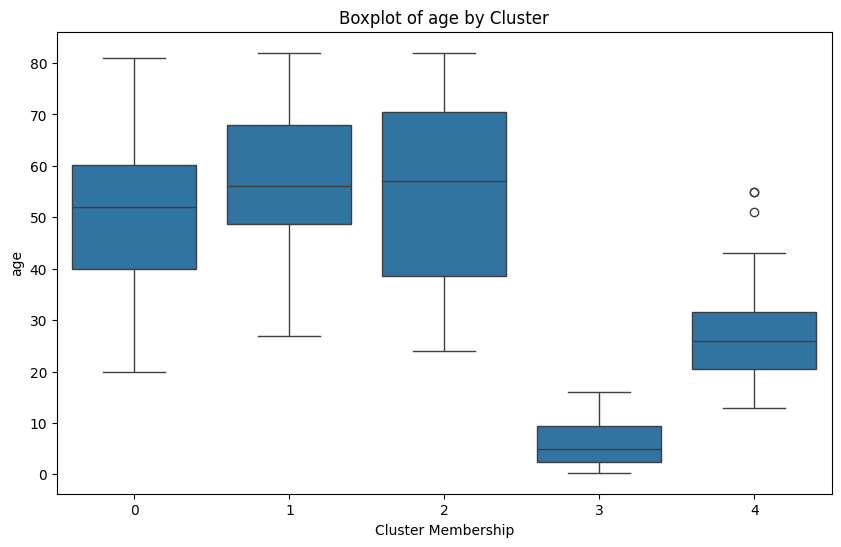

<ipython-input-46-90bf80f04943>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clusters[i][variable], hist=False, kde=True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-46-90bf80f04943>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or 

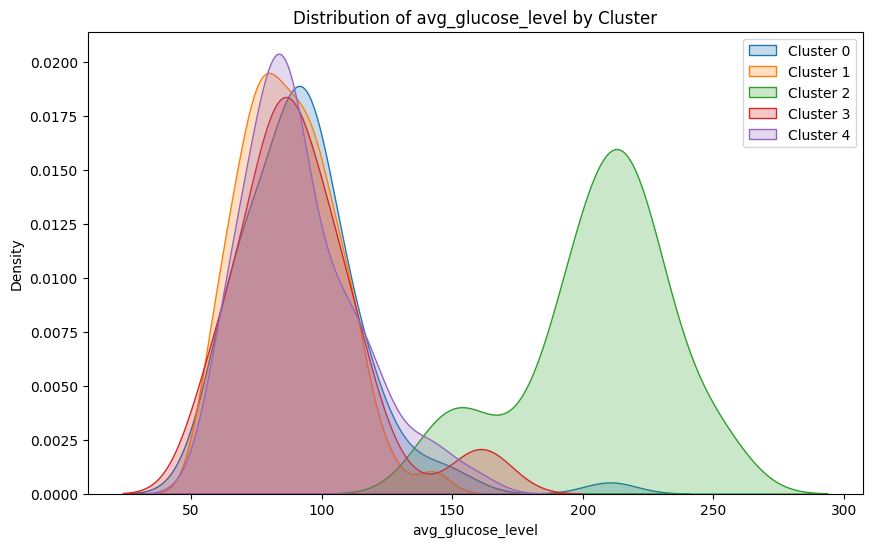

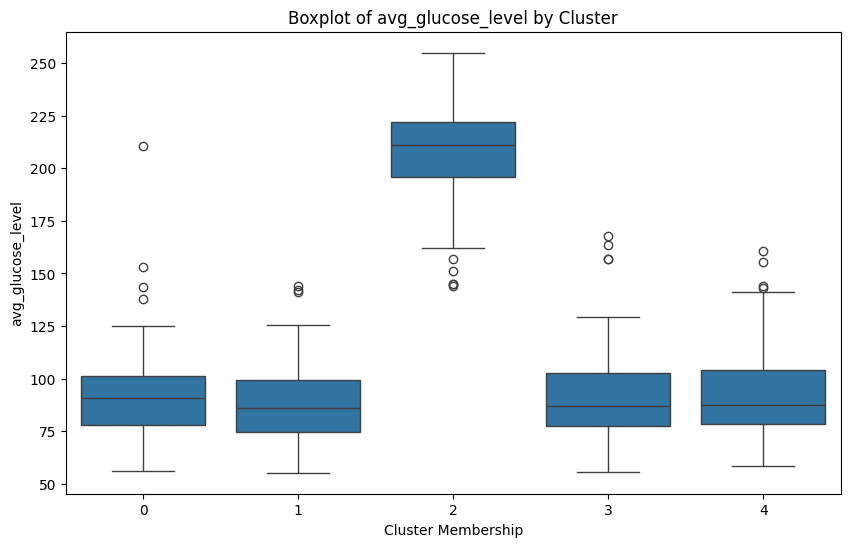

<ipython-input-46-90bf80f04943>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clusters[i][variable], hist=False, kde=True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-46-90bf80f04943>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or 

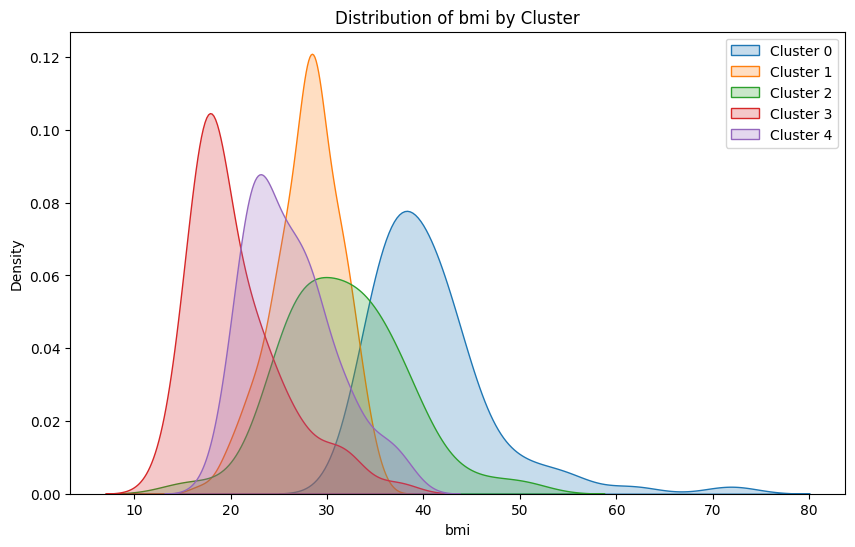

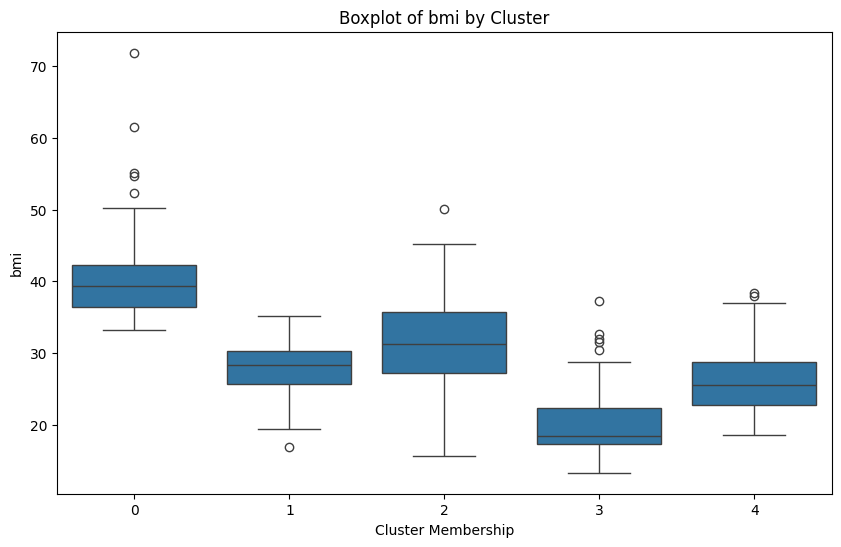

In [46]:
# List of variables you are interested in visualizing
variables_to_plot = ['age', 'avg_glucose_level', 'bmi']

# Plotting distributions or boxplots for each variable
for variable in variables_to_plot:
    plt.figure(figsize=(10, 6))
    for i in range(num_clusters):
        sns.distplot(clusters[i][variable], hist=False, kde=True,
                     kde_kws={'shade': True},
                     label=f'Cluster {i}')
    plt.title(f'Distribution of {variable} by Cluster')
    plt.legend()
    plt.show()

    # Boxplot for the same variable
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster Membership', y=variable, data=subset)
    plt.title(f'Boxplot of {variable} by Cluster')
    plt.show()

In [47]:
print(len(kmeans_labels))  # n of cluster labels
print(len(dataset))        # n of rows in the dataset

# Sample summary:
# 477=subset n, 5110=dataset (df) n
# alignment needed if cluster assignment to dataset

477
5110


Saving subset df as an excel sheet for further analyses and visualizations of the new cluster memberships

In [ ]:
pip install xlsxwriter


In [ ]:
file_path = 'subset_with_clusters_stroke_df.xlsx'

# saving df as Excel file
subset.to_excel(file_path, index=False)

print(f"The subset DataFrame has been successfully saved to {file_path}")